<a href="https://colab.research.google.com/github/ClovisDyArx/SSL/blob/main/TP_Explicabilit%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TP : Explicabilité des modèles de deep learning pour les images avec LIME et SHAP**

## **Objectif**
Ce TP vise à explorer comment interpréter les prédictions d’un modèle de deep learning appliqué aux images à l’aide de **LIME** et **SHAP**. Ces outils permettent d’identifier les parties de l’image qui influencent le plus les décisions du modèle, contribuant ainsi à rendre les modèles plus transparents et compréhensibles.

---

## **Contexte**
Les modèles de deep learning, bien qu’efficaces, sont souvent considérés comme des boîtes noires. Comprendre pourquoi un modèle fait une certaine prédiction est essentiel pour :  
1. Identifier les biais potentiels dans le modèle.  
2. Valider la fiabilité des prédictions dans des applications sensibles.  
3. Construire la confiance des utilisateurs finaux.

Dans ce TP, nous allons :  
1. Charger un modèle de classification d’images pré-entraîné avec PyTorch.  
2. Utiliser ce modèle pour prédire les classes d’images fournies.  
3. Appliquer **LIME** et **SHAP** pour expliquer ces prédictions.  
4. Comparer les visualisations générées par ces deux outils et analyser les résultats.

---

## **Plan du TP**

### **Étape 1 : Préparation de l’environnement**
1. Installer les bibliothèques nécessaires pour PyTorch, LIME, et SHAP.  
2. Télécharger ou préparer un ensemble d’images pour les tests (votre dataset préféré, des images issues d’ImageNet, etc.).

---

### **Étape 2 : Charger un modèle pré-entraîné**
1. Nous allons utiliser un modèle pré-entraîné disponible dans PyTorch, comme ResNet18 ou VGG16, avec des poids pré-entraînés sur ImageNet.  
2. Le modèle sera utilisé pour effectuer des prédictions sur les images, après les avoir redimensionnées et normalisées en fonction des besoins du modèle.  
3. Pour chaque image, nous afficherons les classes prédites avec leurs scores de confiance.

---

### **Étape 3 : Explicabilité avec LIME**
1. **Présentation de LIME :**  
   LIME fonctionne en créant des perturbations localisées sur une image (par exemple, en masquant des zones spécifiques) pour mesurer l’impact de chaque zone sur la prédiction.  
2. **Étapes :**  
   - Segmenter l’image en pixels ou en superpixels.  
   - Identifier les zones les plus influentes pour une prédiction donnée.  
   - Générer une heatmap mettant en évidence les zones importantes pour la classe prédite.  
3. Nous analyserons les résultats pour comprendre quelles parties de l’image influencent le plus la prédiction.

---

### **Étape 4 : Explicabilité avec SHAP**
1. **Présentation de SHAP :**  
   SHAP utilise la théorie des jeux pour attribuer une importance à chaque pixel ou groupe de pixels, en mesurant leur contribution à la prédiction.  
2. **Étapes :**  
   - Fournir les images prétraitées au modèle pour calculer les valeurs SHAP.  
   - Générer une visualisation qui montre les contributions positives et négatives des pixels ou des superpixels pour la prédiction.  
3. Nous interpréterons les visualisations en observant les zones qui favorisent ou défavorisent la classe prédite.

---

### **Étape 5 : Comparaison et analyse des résultats**
1. **Comparaison des visualisations :**  
   - Identifier les différences et similitudes entre les résultats de LIME et SHAP.  
   - Analyser les zones mises en évidence par chaque méthode.  
2. **Discussion :**  
   - Quels sont les points forts et limites de chaque méthode ?  
   - Les deux approches donnent-elles des explications cohérentes ?  
   - Quels défis rencontrons-nous en utilisant ces outils avec des modèles de grande taille ou des images complexes ?

---

## **Livrables attendus**
1. Les heatmaps générées par LIME et SHAP pour au moins deux images.  
2. Une analyse comparative des résultats obtenus avec LIME et SHAP.  
---

# **Préparation de l'environnement**

In [48]:
!pip install lime

In [153]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries

import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16

import torch
import torch.nn as nn
import torch.optim as optim

import shap

from lime.lime_image import LimeImageExplainer
from lime import lime_image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [137]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


# **Chargement modèle pré-entraîné**

In [138]:
model = vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, len(classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 2
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):  # Use trainloader for training
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradient
        optimizer.zero_grad()

        # Forward + backward + optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Print loss every 100 batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Training done.')

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

# **Explicabilité avec LIME**

  0%|          | 0/1000 [00:00<?, ?it/s]

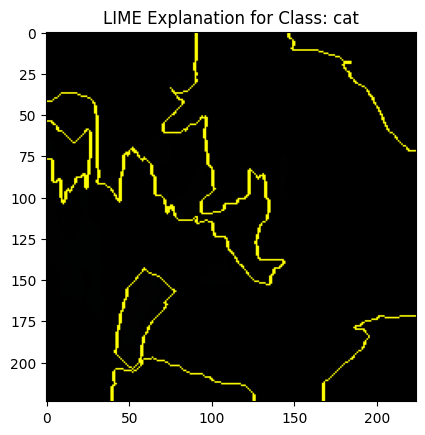

In [142]:
dataiter = iter(testloader)
images, labels = next(dataiter)
image = images[0].to(device)

def predict_fn(images):
    images = torch.tensor(images.transpose(0, 3, 1, 2)).to(device, dtype=torch.float32)
    outputs = model(images)
    return outputs.detach().cpu().numpy()

explainer = LimeImageExplainer()
explanation = explainer.explain_instance(
    images[0].cpu().numpy().transpose(1, 2, 0),
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f'LIME Explanation for Class: {classes[labels[0]]}')
plt.show()

# **Explicabilité avec SHAP**

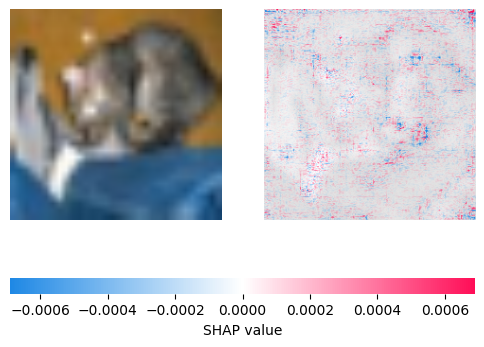

In [152]:
# Ensure no in-place operations in the model (e.g., ReLU(inplace=True))
for module in model.modules():
    if isinstance(module, torch.nn.ReLU):
        module.inplace = False

# Create a SHAP explainer with a background dataset
background = images[:batch_size].to(device)  # Provide some representative images as background
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for the first image
shap_values = explainer.shap_values(image.unsqueeze(0).to(device))

# De-normalize the image for visualization
image_np = images[0].cpu().numpy().transpose(1, 2, 0)
image_np = image_np * std + mean

# Plot SHAP values
shap.image_plot([shap_values[0][0]], image_np)
